## ML Project

In this Capstone Project we will be engaging with the stock price data for several hundred stocks over 5 years, which can be found at:
(./Data/prices-split-adjusted.csv.zip).  The data is from [Kaggle](https://www.kaggle.com/dgawlik/nyse#prices-split-adjusted.csv) and is available in its original form there under a CC0 license. We will be using a slightly preprocessed version in the repo.  

In this notebook we will be looking at financial forecasting with machine learning.  This is inherently one of the hardest problems in machine learning, because some of the most advanced and well-funded technical teams in the world are trying to use machine learning and other techniques to find patterns in the financial data.  When they find patterns and if they trade on those findings, prices will move in a way that makes those patterns less pronounced over time. This is not to say that this is not a fun and rewarding area.  Just do not get discouraged if you don't find an instant money machine.  

### Outline:
0. Background

1. Preparing our tools

2. Importing and describing the data.

3. Exploring, cleaning and visualizing the data

3. Developing analytics

4. Preparing and splitting our data

5. Building our first model

6. Extending to other ML models

7. Ideas for further strategies

8. Wrapping up

### Options
As we progress you are encouraged to take this dataset further. You are also encouraged to explore any aspects of the data. Develop your own algorithms. Be explicit about your inquiry and success in predicting effects on our world.

### Warning: Not financial advice
This exercise is meant purely for educational purposes, uses many simplifications and is not intended, nor should be considered as financial advice. There are many risks involved in implementation of financial trading strategies that are not considered nor described here.

### Setting up
If you have not yet set up your environment, you can easily do so with VS Code, and the python extension and Anaconda.  

For VSCode go here: [https://code.visualstudio.com/]

and then you can follow these instructions:
[https://code.visualstudio.com/docs/python/data-science-tutorial]

0. Background

Machine learning is of increasing importance in finance. As volumes of data grow ever faster, the need for machine driven models to find patterns in that data becomes ever more important.  In the ever-accelerating race to better process data into predictions about securities prices, machine learning has become an important tool, because it is good at finding patterns in large amounts of data.  Today we will be examining patterns in stock prices themselves to practice developing models to predict future set prices. If there are systematic trends, patterns or reversals, then we may detect them. 

While the chances that we discover totally new and unexploited price patterns today is low, we will practice organizing our data, creating and analyzing machine learning models that will give us the tools to develop state of the art signals of value.

Goals: 

1. Become familiar and practice the process of building machine learning models as they relate to financial data.  

2. Understand the special processing that is required when working with time series data such those found in finance.



### 1. Preparing our tools.

Let's review our standard imports:
- numpy for rapid numerical calculations with fast vectorized C implementations
- pandas for processing data
- matplotlib and Seaborn for visualizing charts
- scikit-learn (imported as sklearn) is the de facto standard machine learning library in the pydata ecosystem.  
 
Additionally, we will be using [pandas_profiling](https://github.com/pandas-profiling/pandas-profiling) which is a newer convenience package that helps by putting together much of our initial *boilerplate* exploratory data analysis code. 


In [23]:
# Bring our tools in:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

### Importing and describing the data

Now we are ready to import our data.  The value rows can be set if you only want to import a small subset due to computer memory or speed constraints.

In [24]:
# We are using information from the data source description to know that date is a column containing just what is says
rows = None
stocks = pd.read_csv('./Data/prices-split-adjusted.csv.zip', nrows=rows, parse_dates=['date'], index_col='date')

Now that we have our data successfully loaded, let's explore what we have. First, summarize the dataframe via the info method to validate the data reading and parsing.  When looking at the info report, it is best practice to note that each column is the expected type, noting that strings are reported as object.  Also note if there are null values, how many values there are and what the columns are.  

We do not have a data dictionary in this case.  But if you were lucky enough to have access to a data dictionary, this is a good time to check that the dictionary matches what you actually have.  Discrepancies could be the result of mis-parsing, undocumented schema changes, documentation that is not up to date, or a number of other reasons.  

In [25]:
stocks.info() # Look at the descriptions of the columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


Everything looks as expected in info.  The string column symbol is the trading symbol, also known in finance as the ticker.  The dates were parsed as expected and all the other columns are numeric.  Now we can look at the first few rows of data to get a sample view.  

In [26]:
stocks.head(10)

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0
2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0
2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0
2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0


While the head gives a good preview of a piece of the data, it may not be a great overall view of the entire dataset, especially for larger data sets or ones that may have been sorted at some point.  However, we are more comfortable that the dates were parsed correctly.  We can investigate numerical columns with describe.  

In [27]:
stocks.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08



#### Pandas Profiling
Data exploration can start with a turnkey tool like pandas-profiling.  The important this with this is to make sure you actually look at the report and digest the output.  Make it the start of your investigation.

Instructor note:

Let students take a minute to look at this report.  See what they find.  You may want to do a think, pair, share or another form of reflection.  We run this report with minimal=True because the data set is large, and this avoids slow calculations.  

Then go through the report and show students what they should be looking at for example: the number of variables, the number of observations, duplicate rows.  
Be sure to point out that there is a warning that symbol has high cardinality. This warning is OK because we have data on a large number of stocks. It is expected with this data set and is typical of many finance data sets where there are many instruments.  

Students may be interested to note the long tail in the numeric columns that can be seen in the histograms of each variable (in the variables section).  The histogram combines data from many different stocks so the variation in variables like closing price "close", or in "volume" is greater and shows a long tail.

You can show the output in either a more dynamic widget or in an iframe using either of these lines of code:  

profile.to_widgets()

profile.to_notebook_iframe()


In [28]:
# Minimal avoids expensive calculations that won't have much insight for us and are slow.
profile = ProfileReport(stocks, minimal=True)
profile.to_widgets()

#### Exercise: 

Examine this report and see what insights you notice.  What do you notice about the data?  Are there ways to slice the data that would give more information?    

Instructor notes: 
Students can take a few minutes to do their own exploration.  If students don't see much or you covered this thoroughly, you can suggest that they dig into a particular stock by running a report on an individual stock, letting them choose their own symbol.  A sample code response follows the empty cell provided for student responses.  
In the provided answer highlighting Microsoft, you can see that the variables have some tail, but not the same extremes as when many stocks were combined.  Point out that if they were doing this at work, they would probably look at each stock individually and really get to know their data.  Or at least do so for a representative sample, if not every stock.  

In [29]:
# Blank cell left for student exploration

In [30]:
# Instructor sample answer
profile = ProfileReport(stocks[stocks['symbol']=='MSFT'], minimal=False)
profile.to_widgets()

Looking at an individual stock gives a much clearer impression of the distributions of each column.  Even if you can not do this for every stock, taking a sample can be very helpful.  


### 2. Exploring, cleaning and visualizing the data

#### Modeling our data
One of the most important steps in preparing your data is to think of how we want to think about it.  For those who have worked with SQL, this is like identifying what the key to your table is. For this data exploration, we can think of the index into the data as being a a compound key of both the symbol (the ticker) and the date.  We will process the data in a way that will make a time series model for each stock.  Predicting the future based on what has happened in the past for that individual stock.  

Thought Question: Can you think of other ways that you might want to consider this data?  What questions might prompt you to think of this data having a different data model?  The data model is not fixed but is a lens that lets us look at our data.  




Instructor notes: (Sample answer) Perhaps we would be interested in studying certain holidays affect the variance in volumes?  Perhaps we have a hypothesis that just a few stocks heavily traded on holidays and most others have light trading.  Then we might only have the date as our key as we consider cross sectional data. 

Hopefully students will have other answers.  

#### Visualizing our data
It is often helpful to look at our data visually to see if there are any issues that "look funny."  With experience, just looking at the data can help us understand it in a short amount of time.  This is often the step where domain expertise (in this case the financial markets) is especially useful.  Be sure to look at the histograms of the report above to see if they make sense to you.  

Exercise: 
Are there other visualizations that would give you greater understanding?

In [31]:
# left blank for student answer

In [32]:
# Instructor notes
# Let's look at how many stocks have data for each date
counts = stocks[['symbol']].groupby('date').count()
counts.head(20) 

,symbol
date,
2010-01-04,467
2010-01-05,468
2010-01-06,468
2010-01-07,468
2010-01-08,468
2010-01-11,468
2010-01-12,468
2010-01-13,468
2010-01-14,468


Text(0.5, 1.0, 'Number of stocks with data on each date')

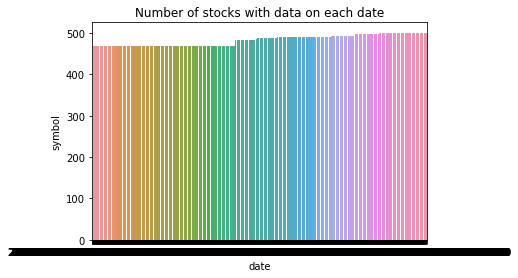

In [33]:
# Instructor notes continued
# This is much clearer with a quick visualization
sns.barplot(x=counts.index, y=counts['symbol'])
plt.title('Number of stocks with data on each date')

Instructor notes: 

This display shows us that the most stocks are available on the latest date. This is an indication that we may have survivor bias. A bias in financial datasets where securities representing firms that go out of business are not included.  

We cannot yet be sure that we have for the survivorship bias, but it is something to note.  Students might want to investigate this later. 

### 3. Feature engineering
For modelling data with machine learning, it is helpful to transform the data into a form that is closer to the theoretical expectations where the ML models should perform well. Let's transform the data into returns and generate other features.  We will transform returns with logarithms based on financial research that log returns are closer to normally distributed and (statistically) stable. 

**The function below is just a sample of feature transformations.  Taking the logarithms can help deal with skewed data as we saw we have in the pandas-profile report.**

To be honest, which variables you use and how you transform them is largely dependent on domain expertise and traditions of the field. It can also be a matter of trial and error, although that can lead to overfitting.  We will discuss overfitting a little bit later.

In [34]:
def feature_target_generation(df):
    """
    df: a pandas dataframe containing numerical columns
    num_days_ahead: an integer that can be used to shift the prediction value from the future into a prior row.
    """

    # The following line ensures the data is in date order    
    features = pd.DataFrame(index=df.index).sort_index() 
    features['f01'] = np.log(df.close / df.open) # intra-day log return
    features['f02'] = np.log(df.open / df.close.shift(1)) # overnight log return

    features['f03'] = df.volume # try both regular and log volume
    features['f04'] = np.log(df.volume) 
    features['f05'] = df.volume.diff() # 1-day absolute change in volume
    features['f06'] = df.volume.pct_change() # 1-day relative change in volume
    # The following are rolling averages of different periods
    features['f07'] = df.volume.rolling(5, min_periods=1).mean().apply(np.log)
    features['f08'] = df.volume.rolling(10, min_periods=1).mean().apply(np.log)
    features['f09'] = df.volume.rolling(30, min_periods=1).mean().apply(np.log)

    # More of our original data: low, high and close
    features['f10'] = df.low 
    features['f11'] = df.high
    features['f12'] = df.close
    # The Intraday trading spread measures how far apart the high and low are
    features['f13'] = df.high - df.low 
    # These are log returns over different time periods 
    features['f14'] = np.log(df.close / df.close.shift(1)) # 1 day log return
    features['f15'] = np.log(df.close / df.close.shift(5)) # 5 day log return
    features['f16'] = np.log(df.close / df.close.shift(10)) # 10 day log return
    return features

In Machine Learning, we need to predict something, typically called our target or predictor. 

Let's predict the value of the stock price 10 days into the future, using "prediction_horizon".  Here 10 is a hyperparameter that is somewhat arbitrary.  We may want to try different horizons to see if we are better at predicting the near future or the long term.  

The ticker lets us start by testing on a single stock for speed in training.  

We want to look at different periods of history to see how we do.  We will use overlapping sets with n_splits.  

In [35]:
# Let's generate a list of tickers so we can easily select them
ticker_list = stocks.symbol.unique()

# these are hyperparameters you can play with or tune
prediction_horizon = -5 # this is a negative number by convention
ticker = 'MSFT' # choose any ticker
n_splits = 5 

# Make an individual model for each ticker/symbol
features = feature_target_generation(stocks[stocks.symbol==ticker])

### 5. Preparing and splitting our data
It is important that we separate our training and test data.  Since our rows are already time ordered, we can easily do splits.  This is one of the areas where times series data is different from other machine learning problems.  

In [36]:
# We are trying to predict the price prediction_horizon days in the future.  So we take the future value and move it prediction_horizon into the past to line up our data in the Scikit-learn format.  
y = features.f12.shift(prediction_horizon)
# The latest (prediction_horizon) rows will have nans because we have no future data, so let's drop them.
shifted = ~np.isnan(y)
X = features[y.notna()] # Remove the rows that do not have valid target values
y = y[shifted] # Remove the rows that do not have valid target values

# Split the history into different backtesting regimes
tscv = TimeSeriesSplit(n_splits=n_splits)
print(tscv)

TimeSeriesSplit(max_train_size=None, n_splits=5)


In [37]:
 # Review the features
 features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f01     1762 non-null   float64
 1   f02     1761 non-null   float64
 2   f03     1762 non-null   float64
 3   f04     1762 non-null   float64
 4   f05     1761 non-null   float64
 5   f06     1761 non-null   float64
 6   f07     1762 non-null   float64
 7   f08     1762 non-null   float64
 8   f09     1762 non-null   float64
 9   f10     1762 non-null   float64
 10  f11     1762 non-null   float64
 11  f12     1762 non-null   float64
 12  f13     1762 non-null   float64
 13  f14     1761 non-null   float64
 14  f15     1757 non-null   float64
 15  f16     1752 non-null   float64
dtypes: float64(16)
memory usage: 234.0 KB


### 6. Building our first model
This is a regression problem.  Why is that so? 




Instructor notes:

This is a regression problem because it is predicting a price, which is a continuous value.  

#### Linear regression
In our ML framework we can use linear regression, just as in standard statistics or econometrics.

In [38]:
def model_ts_report(model, tscv, X, y, impute=False):
    """
    Fit the model and then run time series backtests.
    """
    # Loop through the backtests
    for train_ind, test_ind in tscv.split(X): 
        # Report on the time periods
        print(f'Train is from {X.iloc[train_ind].index.min()} to {X.iloc[train_ind].index.max()}. ')
        print(f'Test is from {X.iloc[test_ind].index.min()} to {X.iloc[test_ind].index.max()}. ')
        # Generate training and testing features and target for each fold.
        X_train, X_test = X.iloc[train_ind], X.iloc[test_ind]
        y_train, y_test = y.iloc[train_ind], y.iloc[test_ind]

        if impute==True:
            # Since linear regression cannot deal with NaN, we need to impute.  There may be the better choices.
            X_train.fillna(df.mean(), inplace=True)
            X_test.fillna(df.mean(), inplace=True)
        
        # Fit the model
        model.fit(X_train, y_train)

        # Predict and measure on the training data
        y_pred_train = model.predict(X_train) 
        print("Training results:")
        print("RMSE:", mean_squared_error(y_train, y_pred_train, squared=False))

        # Predict and measure on the testing data
        y_pred_test = model.predict(X_test)
        print("Test results:")
        print("RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))
        print("")
    

In [39]:
from sklearn.linear_model import LinearRegression
# Fit and report on a linear model
lm = LinearRegression()
model_ts_report(lm, tscv, X, y, impute=True)

Train is from 2010-01-04 00:00:00 to 2011-03-08 00:00:00. 
Test is from 2011-03-09 00:00:00 to 2012-05-03 00:00:00. 


NameError: name 'df' is not defined

As we look at our results, we can see that in each period we do better in training than in testing.  That is typical of finance and machine learning more generally. 
Interestingly, we are able to explain 90% of the variance with our first linear model.  

If you have questions about the root-mean-squared-error (RMSE), please see the Microsoft learn module on machine learning.

#### Ensemble Model
Let's try a Random Forest, which is a commonly used model that blends a group of decision trees, each of which have access to a sub-sample of features.  It is commonly used because it it tends to work well with relatively little tuning of hyperparameters and is somewhat less likely to overfit.  This is NOT a classic model commonly used in econometrics, mainly because it does not have a linear structure that corresponds with econometric theory.  However, it is often used in predictions for items other than finance.  


In [ ]:
# Initiate a Random Forest
rf = RandomForestRegressor()
model_ts_report(rf, tscv, X, y, impute=True) # Report on the random forest

By using a Random Forest, we are able to bring down our training data error metrics by a lot (over 50% decrease on RMSE)!  However, our test results are not as good for most of the time slices.  This is an indication that we are *overfitting* our model to the training data.  This model would likely not do as well in production as it would in our backtests.  Why?  Because our models have not done well on any of the new data, outside the time period during which they were trained. 

### Open Ended Exercise

Now is your turn to go ahead and improve these models.  Some areas that might help could be to: 
- Tune the existing models (Random forest has a number of parameters that may help) 
- Clean the existing data (Fill missing values better) 
- Try other models such as Support Vector Regressor, Extra Trees Regressor or ElasticNet 
- Try this for more stocks (Just becasue it did not work for one stock, it may still be useful for most stocks) 
- Get more features, through transformations or outside data  


  

Instructor notes: 
Here is an extra trees regressor.  This may do an even better job on training but it still is overfitting.  To have a production useable model we would need to improve performance on the test set. 

In [ ]:
# train an extra trees regressor
et = ExtraTreesRegressor(n_estimators=100, max_depth=4)
model_ts_report(et, tscv, X, y, impute=True) # Report on the extra trees, an extension of the random forest

In [41]:
# This is a different package that is at the 
from xgboost import XGBRegressor

# this is the change
xgb = XGBRegressor(n_jobs=4, n_estimators=200)
model_ts_report(xgb, tscv, X, y, impute=True) # Report on the extra trees, an extension of the random forest

Train is from 2010-01-04 00:00:00 to 2011-03-08 00:00:00. 
Test is from 2011-03-09 00:00:00 to 2012-05-03 00:00:00. 


NameError: name 'df' is not defined